In [8]:
# Imports
import time
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
from fc_utils import *
from cnn_utils import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

#np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# train_data_orig, train_labels_orig, eval_data_orig, eval_labels_orig, classes = load_dataset()
# classes = 6
# train_labels = np.squeeze(train_labels_orig)
# train_labels_old = train_labels
# train_labels = one_hot_label(classes, train_labels_old)
# eval_labels = np.squeeze(eval_labels_orig)
# eval_labels_old = eval_labels
# eval_labels = one_hot_label(classes, eval_labels_old)
# # Flatten the training and test images
# train_data = train_data_orig.reshape(train_data_orig.shape[0], -1).T
# eval_data = eval_data_orig.reshape(eval_data_orig.shape[0], -1).T
# # Normalize image vectors
# train_data = train_data/255.
# eval_data = eval_data/255.
# features = train_data.shape[0]
# print(train_data.shape)

In [10]:
# Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
classes = 10
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
train_labels = one_hot_label(classes, train_labels)
eval_data = mnist.test.images # Returns np.array
eval_labels_old = np.asarray(mnist.test.labels, dtype=np.int32)
eval_labels = one_hot_label(classes, eval_labels_old)
features = train_data.shape[0]

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


(55000, 784)
(10000, 784)


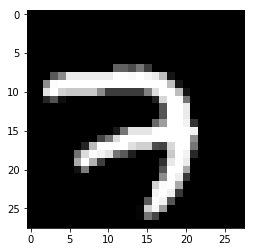

In [11]:
print(train_data.shape)
print(eval_data.shape)
# Input Layer
input_layer = train_data.reshape(55000, 28,28,1)
eval_data = eval_data.reshape(10000, 28, 28, 1)
plt.imshow(input_layer[0,:,:,0])

## Plan
**input layer:** mx28x28x1

**conv layer1 + Relu:** mx28x28x32

**pool layer1:** mx14x14x32

**conv layer2 + Relu:** mx14x14x64

**pool layer2:** mx7x7x64

**flatten:** mx3136

**fc layer1:** mx1024

**output layer:** mx10

**softmax:** mx10

In [37]:
# training model
filter_dims = [(5,5,1,32),(5,5,32,64)]
layers_dims = [3136, 1024, classes] #  2-layer model
parameters, parameters_conv, grads, conv_grads = cnn_model(input_layer[0:1024], train_labels[0:1024], filter_dims, layers_dims, batch_size = 128, learning_rate = 0.01, num_iterations = 5, print_cost = True)

Cost after iteration 0, batch 0: 2.302586
Cost after iteration 0, batch 1: 2.302388
Cost after iteration 0, batch 2: 2.302249
Cost after iteration 0, batch 3: 2.302267
Cost after iteration 0, batch 4: 2.302269
Cost after iteration 0, batch 5: 2.302076
Cost after iteration 0, batch 6: 2.302189


KeyboardInterrupt: 

In [ ]:
out = parameters_conv['W1']
out = np.append(out,parameters_conv['b1'])
out = np.append(out,parameters_conv['W3'])
out = np.append(out,parameters_conv['b3'])
out = out.reshape(-1,1)
print(out)
np.savetxt("conv_para.csv", out, delimiter=",")

In [ ]:
# further training on the same model 
#parameters = FC_layer_model(train_data, train_labels, layers_dims, batch_size = 512, parameters = parameters, learning_rate = 0.5, num_iterations = 5, print_cost = True)

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
eval_model(train_data, train_labels, parameters)
eval_model(eval_data, eval_labels, parameters)

In [ ]:
image_num = 200
predict(eval_data[:,image_num:image_num+1],parameters)
print("actual value: " + str(eval_labels_old[image_num]))
data = mnist.test.images[image_num].reshape(28,28)
plt.imshow(data)